# Censoring - Runner Stays on Third


## Problem

We need a stochastic method for determining if a runner that stayed would have
been tagged out.

## Hypothesis

The tagged out outcome follows a normal distribution and a normal distribution
can be fitted to the data to get the one sided confidence interval. The one-sided
confidence interval can be used to determine if a stay would have been an out or
the stay would have been not a tag out.

In [19]:
import random
import polars as pl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.stats import norm
from models import model_prep_on_base, create_model_pipeline
from sklearn.metrics import make_scorer, recall_score, precision_score, f1_score
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

random.seed(123)

## Data Prep

In [20]:
# Lazy read the data
on_base_lf = pl.scan_parquet("../data/throw_home_runner_on_third_wide_sprint_arm.parquet")

# Create and clean a dataset for runners tagged out
out_lf = (on_base_lf
              .select(["is_out", "distance_catch_to_home"])
              .filter(pl.col("is_out") == True)
              .drop(["is_out"])
              .with_columns(pl.lit("Out").alias("outcome"))
              .drop_nulls(pl.all())
)

# Create and clean a dataset for runners that scored
scored_lf = (on_base_lf
          .select(["is_advance", "distance_catch_to_home"])
          .filter(pl.col("is_advance") == True)
          .drop(["is_advance"])
          .with_columns(pl.lit("Scored").alias("outcome"))
          .drop_nulls(pl.all())
)

# Create and clean a dataset for runners that stayed
stayed_lf = (on_base_lf
          .select(["is_stay", "distance_catch_to_home"])
          .filter(pl.col("is_stay") == True)
          .drop(["is_stay"])
          .with_columns(pl.lit("Stay").alias("outcome"))
          .drop_nulls(pl.all())
)

# Combine all datasets
combined_lf = pl.concat([out_lf, scored_lf, stayed_lf])
combined_pd = combined_lf.collect().to_pandas()
combined_pd

,distance_catch_to_home,outcome
0,264.394729,Out
1,253.113036,Out
2,237.698864,Out
3,253.476871,Out
4,254.035708,Out
...,...,...
6191,225.735989,Stay
6192,222.955221,Stay
6193,293.638466,Stay
6194,224.625747,Stay


In [21]:
out_np = out_lf.select(["distance_catch_to_home"]).collect().to_numpy().flatten()

def bootstrap_upper_one_sided_ci(data, confidence=0.95, n_bootstrap=10000):
    """
    """
    bootstrap_means = []
    n = len(data)
    ci = confidence * 100
    
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=n, replace=True)
        bootstrap_means.append(np.mean(sample))
    
    bound = np.percentile(bootstrap_means, ci)
    print(f"One-sided 95% CI: mean ≤ {bound:.2f}")
    
    return bootstrap_means, bound

bootstrap_means, bound = bootstrap_upper_one_sided_ci(out_np)

One-sided 95% CI: mean ≤ 259.76


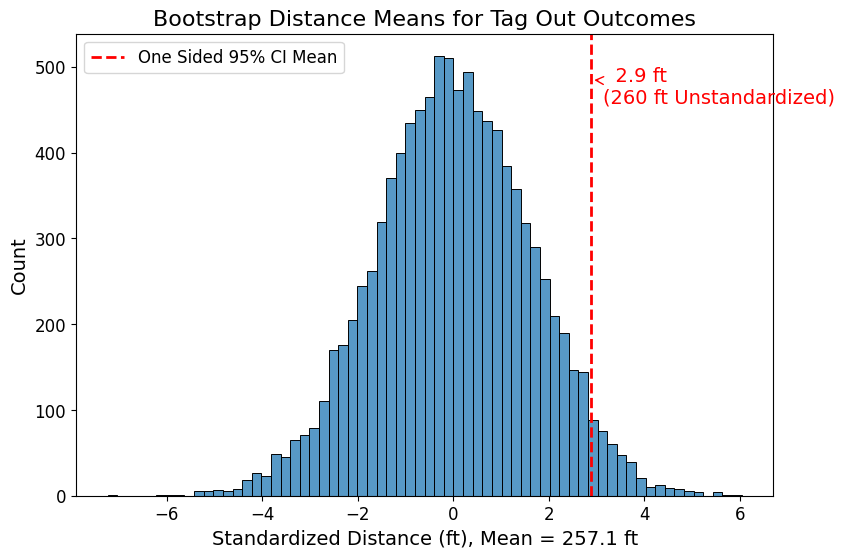

In [22]:
bootstrap_means_centered = bootstrap_means - np.mean(bootstrap_means)
reference_line = 260 - np.mean(bootstrap_means)
mean_value = np.mean(bootstrap_means)

plt.figure(figsize=(9, 6))
sns.histplot(bootstrap_means_centered)
plt.axvline(x=reference_line, color='red', linestyle='--', linewidth=2)
plt.annotate(f'  {reference_line:.1f} ft\n(260 ft Unstandardized)', 
           xy=(reference_line, plt.ylim()[1] * 0.90),  
           xytext=(reference_line + 0.25, plt.ylim()[1] * 0.85),  
           arrowprops=dict(arrowstyle='->', color='red'),
           fontsize=14,
           color='red')

# Create legend handles
from matplotlib.lines import Line2D
vline_handle = Line2D([0], [0], color='red', linestyle='--', linewidth=2)

# Add to legend with standardization info
plt.legend([vline_handle], 
          [f'One Sided 95% CI Mean'], 
          loc='upper left', 
          fontsize=12, 
          title_fontsize=14)

plt.title('Bootstrap Distance Means for Tag Out Outcomes', fontsize=16)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel(f'Standardized Distance (ft), Mean = {mean_value:.1f} ft', fontsize=14)
plt.show()

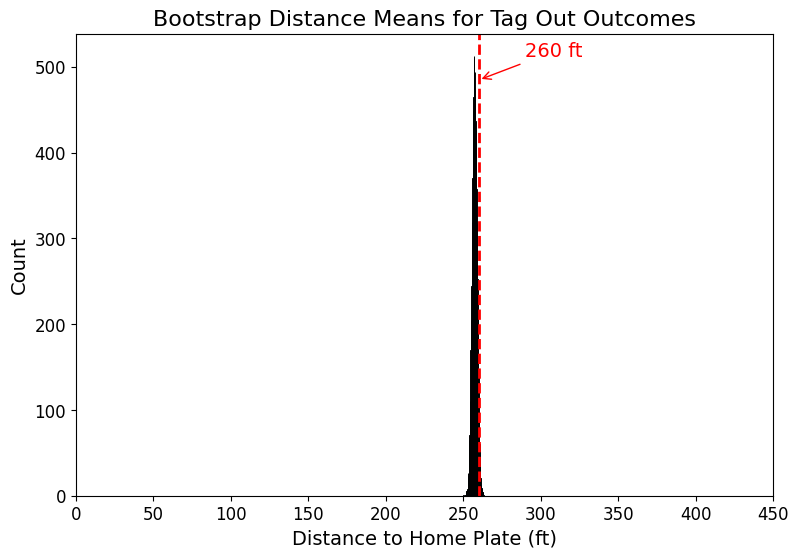

In [23]:
# Create stacked histogram
plt.figure(figsize=(9, 6))
sns.histplot(bootstrap_means)

# Add vertical line and plot annotation
plt.axvline(x=260, color='red', linestyle='--', linewidth=2)
plt.annotate('260 ft', 
           xy=(260, plt.ylim()[1] * 0.90),  
           xytext=(260 + 30, plt.ylim()[1] * 0.95),  
           arrowprops=dict(arrowstyle='->', color='red'),
           fontsize=14,
           color='red')

# Plot Formatting
plt.title('Bootstrap Distance Means for Tag Out Outcomes', fontsize=16)
plt.xlabel('Distance to Home Plate (ft)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(0, 450)

plt.show()

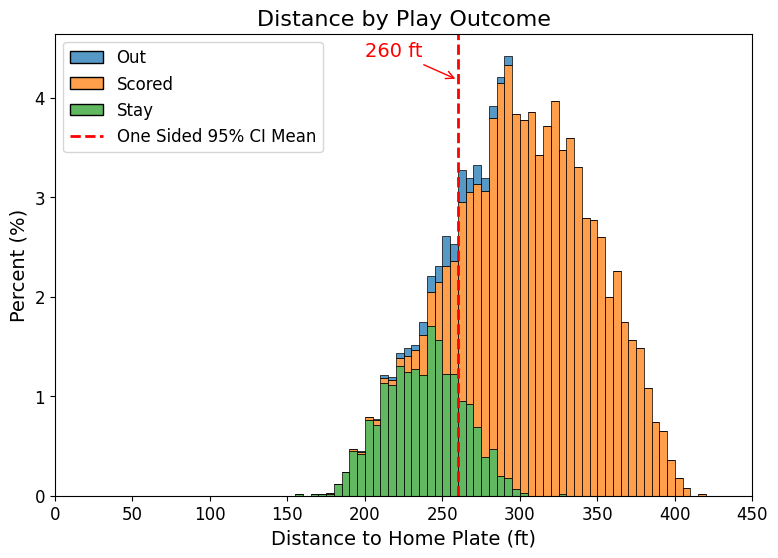

In [24]:
# Create stacked histogram
plt.figure(figsize=(9, 6))
ax = sns.histplot(data=combined_pd, 
                 x="distance_catch_to_home", 
                 hue="outcome",
                 stat="percent", 
                 binrange=(0, 450),
                 binwidth=5,
                 multiple="stack")

# Add vertical line and plot annotation
plt.axvline(x=260, color='red', linestyle='--', linewidth=2)
plt.annotate('260 ft', 
           xy=(260, plt.ylim()[1] * 0.90),  
           xytext=(260 - 60, plt.ylim()[1] * 0.95),  
           arrowprops=dict(arrowstyle='->', color='red'),
           fontsize=14,
           color='red')

# Save the legend for later
legend = ax.get_legend()
handles = legend.legend_handles
labels = [t.get_text() for t in legend.get_texts()]

# Add the vertical line to the legend
vline_handle = Line2D([0], [0], color='red', linestyle='--', linewidth=2)
handles.append(vline_handle)
labels.append('One Sided 95% CI Mean')

# Create legend with each part
plt.legend(handles, labels, loc='upper left', fontsize=12, title_fontsize=14)

# Plot Formatting
plt.title('Distance by Play Outcome', fontsize=16)
plt.xlabel('Distance to Home Plate (ft)', fontsize=14)
plt.ylabel('Percent (%)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(0, 450)

plt.show()

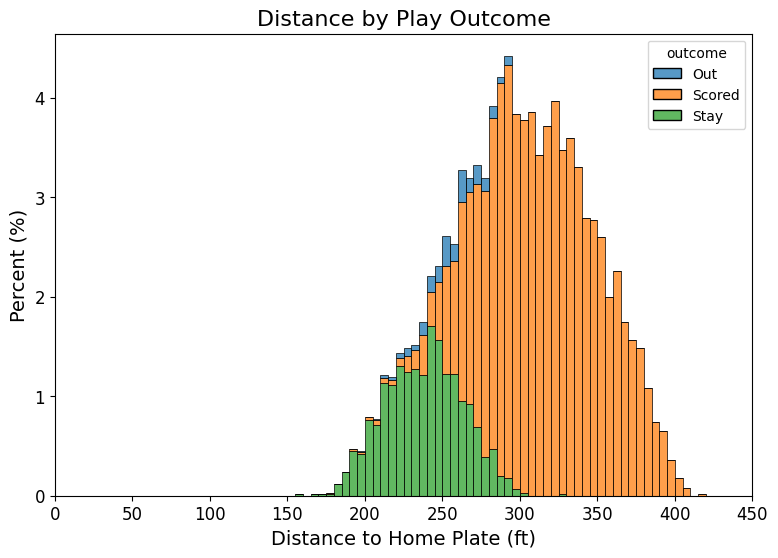

In [25]:

# Create stacked histogram
plt.figure(figsize=(9, 6))
ax = sns.histplot(data=combined_pd, 
                 x="distance_catch_to_home", 
                 hue="outcome",
                 stat="percent", 
                 binrange=(0, 450),
                 binwidth=5,
                 multiple="stack")

# Save the legend for later
legend = ax.get_legend()
handles = legend.legend_handles
labels = [t.get_text() for t in legend.get_texts()]

# Plot Formatting
plt.title('Distance by Play Outcome', fontsize=16)
plt.xlabel('Distance to Home Plate (ft)', fontsize=14)
plt.ylabel('Percent (%)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(0, 450)

plt.show()

In [26]:
combined_censored_lf = combined_lf.with_columns(
    pl.when((pl.col("outcome") == pl.lit("Stay")) & (pl.col("distance_catch_to_home") <= 260))
    .then(pl.lit("Out"))
    .otherwise(pl.col("outcome"))
    .alias("outcome")
)
combined_censored_pd = combined_censored_lf.collect().to_pandas()

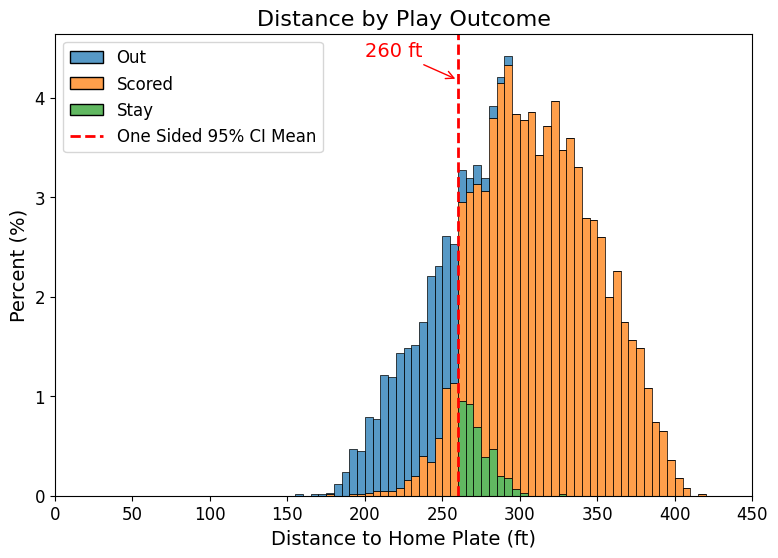

In [27]:
# Create stacked histogram
plt.figure(figsize=(9, 6))
ax = sns.histplot(data=combined_censored_pd, 
                 x="distance_catch_to_home", 
                 hue="outcome",
                 stat="percent", 
                 binrange=(0, 450),
                 binwidth=5,
                 multiple="stack")

# Add vertical line and plot annotation
plt.axvline(x=260, color='red', linestyle='--', linewidth=2)
plt.annotate('260 ft', 
           xy=(260, plt.ylim()[1] * 0.90),  
           xytext=(260 - 60, plt.ylim()[1] * 0.95),  
           arrowprops=dict(arrowstyle='->', color='red'),
           fontsize=14,
           color='red')

# Save the legend for later
legend = ax.get_legend()
handles = legend.legend_handles
labels = [t.get_text() for t in legend.get_texts()]

# Add the vertical line to the legend
vline_handle = Line2D([0], [0], color='red', linestyle='--', linewidth=2)
handles.append(vline_handle)
labels.append('One Sided 95% CI Mean')

# Create legend with each part
plt.legend(handles, labels, loc='upper left', fontsize=12, title_fontsize=14)

# Plot Formatting
plt.title('Distance by Play Outcome', fontsize=16)
plt.xlabel('Distance to Home Plate (ft)', fontsize=14)
plt.ylabel('Percent (%)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(0, 450)

plt.show()

In [28]:
combined_binary_lf = (combined_lf
    .with_columns(
        pl.when(pl.col("outcome") != pl.lit("Out"))
        .then(pl.lit("Not Out"))
        .otherwise(pl.col("outcome"))
        .alias("outcome")
    )
) 

combined_binary_pd = combined_binary_lf.collect().to_pandas()

combined_censored_binary_lf = (combined_lf
    .with_columns(
        pl.when((pl.col("outcome") == pl.lit("Stay")) & (pl.col("distance_catch_to_home") <= 260))
        .then(pl.lit("Out"))
        .otherwise(pl.col("outcome"))
        .alias("outcome"))
    .with_columns(
        pl.when(pl.col("outcome") != pl.lit("Out"))
        .then(pl.lit("Not Out"))
        .otherwise(pl.col("outcome"))
        .alias("outcome")
    )
)

combined_censored_binary_pd = combined_censored_binary_lf.collect().to_pandas()

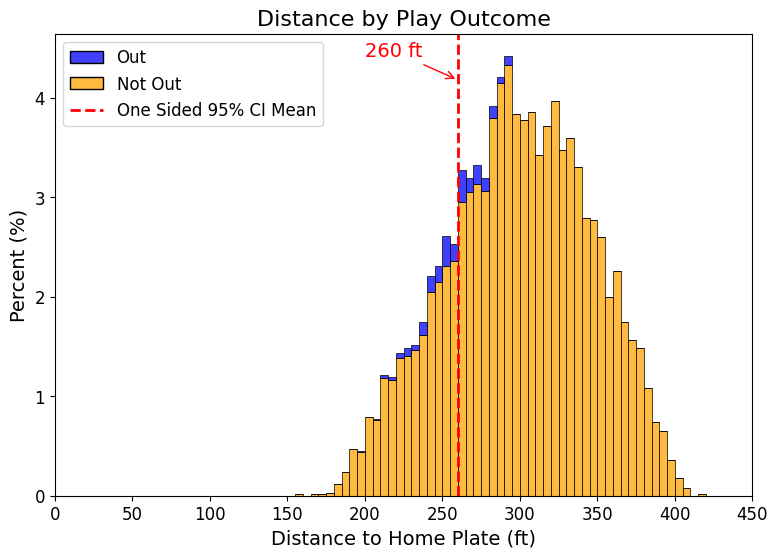

In [29]:
# Create stacked histogram
plt.figure(figsize=(9, 6))
ax = sns.histplot(data=combined_binary_pd, 
                 x="distance_catch_to_home", 
                 hue="outcome",
                 stat="percent", 
                 binrange=(0, 450),
                 binwidth=5,
                 palette=["blue", "orange"],
                 multiple="stack")

# Add vertical line and plot annotation
plt.axvline(x=260, color='red', linestyle='--', linewidth=2)
plt.annotate('260 ft', 
           xy=(260, plt.ylim()[1] * 0.90),  
           xytext=(260 - 60, plt.ylim()[1] * 0.95),  
           arrowprops=dict(arrowstyle='->', color='red'),
           fontsize=14,
           color='red')

# Save the legend for later
legend = ax.get_legend()
handles = legend.legend_handles
labels = [t.get_text() for t in legend.get_texts()]

# Add the vertical line to the legend
vline_handle = Line2D([0], [0], color='red', linestyle='--', linewidth=2)
handles.append(vline_handle)
labels.append('One Sided 95% CI Mean')

# Create legend with each part
plt.legend(handles, labels, loc='upper left', fontsize=12, title_fontsize=14)

# Plot Formatting
plt.title('Distance by Play Outcome', fontsize=16)
plt.xlabel('Distance to Home Plate (ft)', fontsize=14)
plt.ylabel('Percent (%)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(0, 450)

plt.show()

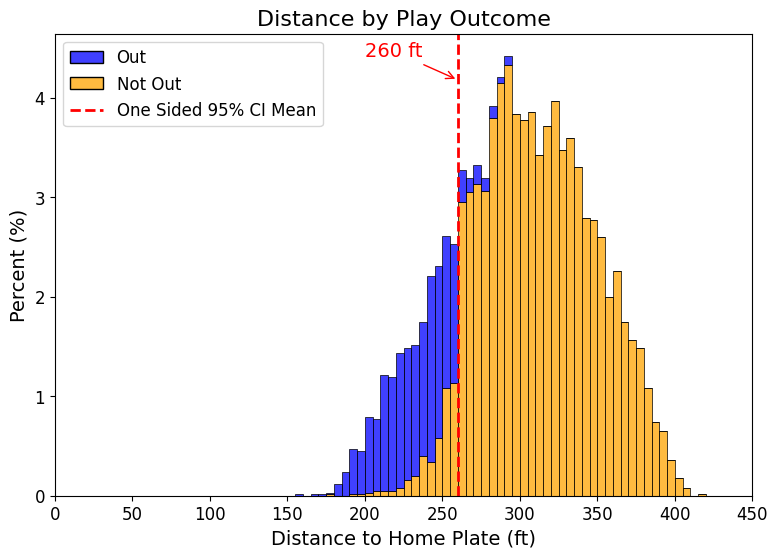

In [30]:
# Create stacked histogram
plt.figure(figsize=(9, 6))
ax = sns.histplot(data=combined_censored_binary_pd, 
                 x="distance_catch_to_home", 
                 hue="outcome",
                 stat="percent", 
                 binrange=(0, 450),
                 binwidth=5,
                 palette=["blue", "orange"],
                 multiple="stack")

# Add vertical line and plot annotation
plt.axvline(x=260, color='red', linestyle='--', linewidth=2)
plt.annotate('260 ft', 
           xy=(260, plt.ylim()[1] * 0.90),  
           xytext=(260 - 60, plt.ylim()[1] * 0.95),  
           arrowprops=dict(arrowstyle='->', color='red'),
           fontsize=14,
           color='red')

# Save the legend for later
legend = ax.get_legend()
handles = legend.legend_handles
labels = [t.get_text() for t in legend.get_texts()]

# Add the vertical line to the legend
vline_handle = Line2D([0], [0], color='red', linestyle='--', linewidth=2)
handles.append(vline_handle)
labels.append('One Sided 95% CI Mean')

# Create legend with each part
plt.legend(handles, labels, loc='upper left', fontsize=12, title_fontsize=14)

# Plot Formatting
plt.title('Distance by Play Outcome', fontsize=16)
plt.xlabel('Distance to Home Plate (ft)', fontsize=14)
plt.ylabel('Percent (%)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(0, 450)

plt.show()

In [31]:

combined_censored_binary_lf = (combined_lf
    .with_columns(
        pl.when((pl.col("outcome") == pl.lit("Stay")) | (pl.col("outcome") == pl.lit("Out")))
        .then(pl.lit("Stay or Out"))
        .otherwise(pl.col("outcome"))
        .alias("outcome"))
    .with_columns(
        pl.when(pl.col("outcome") != pl.lit("Stay or Out"))
        .then(pl.lit("Scored"))
        .otherwise(pl.col("outcome"))
        .alias("outcome")
    )
)

combined_censored_binary_pd = combined_censored_binary_lf.collect().to_pandas()

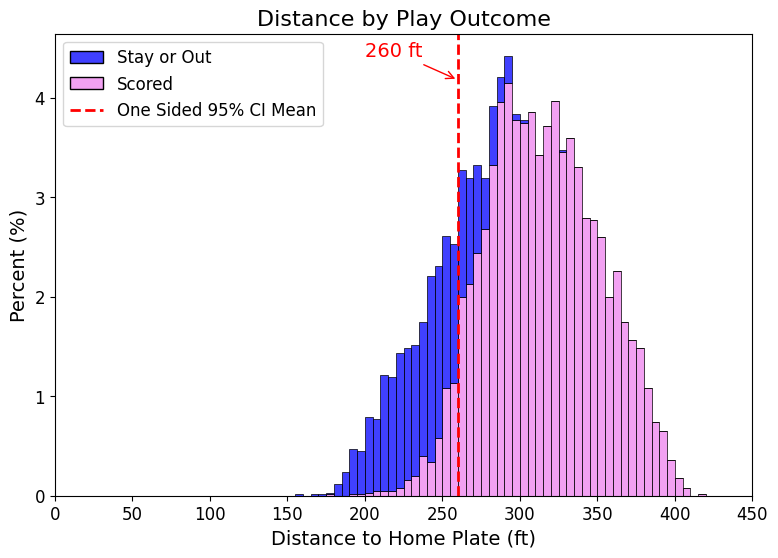

In [32]:
# Create stacked histogram
plt.figure(figsize=(9, 6))
ax = sns.histplot(data=combined_censored_binary_pd, 
                 x="distance_catch_to_home", 
                 hue="outcome",
                 stat="percent", 
                 binrange=(0, 450),
                 binwidth=5,
                 palette=["blue", "violet"],
                 multiple="stack")

# Add vertical line and plot annotation
plt.axvline(x=260, color='red', linestyle='--', linewidth=2)
plt.annotate('260 ft', 
           xy=(260, plt.ylim()[1] * 0.90),  
           xytext=(260 - 60, plt.ylim()[1] * 0.95),  
           arrowprops=dict(arrowstyle='->', color='red'),
           fontsize=14,
           color='red')

# Save the legend for later
legend = ax.get_legend()
handles = legend.legend_handles
labels = [t.get_text() for t in legend.get_texts()]

# Add the vertical line to the legend
vline_handle = Line2D([0], [0], color='red', linestyle='--', linewidth=2)
handles.append(vline_handle)
labels.append('One Sided 95% CI Mean')

# Create legend with each part
plt.legend(handles, labels, loc='upper left', fontsize=12, title_fontsize=14)

# Plot Formatting
plt.title('Distance by Play Outcome', fontsize=16)
plt.xlabel('Distance to Home Plate (ft)', fontsize=14)
plt.ylabel('Percent (%)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(0, 450)

plt.show()

## Unmodified Train and Test, Full Model (All Predictors)

In [33]:

# Feature column names
responses = ["is_out"]

num_predictors_drop = [
    "hang_time",
  "distance_catch_to_home",
  "distance_traveled_fielder",
  "distance_traveled_all_fielders",
  "distance_to_home_diff",
  "distance_catch_to_first",
  "distance_catch_to_second",
  "distance_catch_to_third"
]

num_predictors_median = [
      "seconds_since_hit_085_mlb_person_id_R3",
  "arm_overall_fielder_mlb_person_id",
]

# Parameter grid
param_grid = {
    'classifier__penalty': ['elasticnet'],
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
    'classifier__solver': ['saga'],
    'classifier__max_iter': [100, 250, 500, 1000]
}

# Scoring method
specificity_scorer = make_scorer(recall_score, pos_label=1)
precision_pos_scorer = make_scorer(precision_score, pos_label=1, zero_division=0)
f1_pos_scorer = make_scorer(f1_score, pos_label=1, zero_division=0)
scoring = {
    'log_loss': 'neg_log_loss',
    'brier_score': 'neg_brier_score'
}
refit = "brier_score"

# Train model
grid_search = create_model_pipeline(
    num_predictors_drop=num_predictors_drop,
    num_predictors_median=num_predictors_median,
    model_type="LogisticRegression",
    oversampling_method="SMOTE",
    param_grid=param_grid,
    scoring=scoring,
    refit=refit,
    cv=5,
)

# Unmodified Train and Unmodified Test
results = model_prep_on_base(
    on_base_lf = on_base_lf,
    grid_search = grid_search,
    responses = responses,
    num_predictors_drop = num_predictors_drop,
    num_predictors_median = num_predictors_median,
    test_size = 0.30,
    is_out_censored = False,
    test_stay_to_out = False,
    test_stay_to_out_threshold = False,
)

pipeline = results['pipeline']
X_train = results['X_train']
X_test = results['X_test']
y_train = results['y_train']
y_test = results['y_test']
y_pred = results['y_pred']
y_pred_proba = results['y_pred_proba']
brier_score = results['brier_score']
log_loss = results['log_loss']
feature_names = results['feature_names']
response_names = results['response_names']

pipeline

Total features: 11
Total Predictors: 10
Total Responses: 1
Fitting 5 folds for each of 120 candidates, totalling 600 fits


/Users/william/git/Sacrifice-Fly-Modeling/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/william/git/Sacrifice-Fly-Modeling/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/william/git/Sacrifice-Fly-Modeling/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/william/git/Sacrifice-Fly-Modeling/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/william/git/Sacrifice-Fly-Modeling/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reac


Best parameters: 
classifier__C = 100
classifier__l1_ratio = 0.9
classifier__max_iter = 1000
classifier__penalty = elasticnet
classifier__solver = saga

Best cross-validation score: -0.1001

              precision    recall  f1-score   support

       False       0.99      0.87      0.93      1444
        True       0.15      0.81      0.26        42

    accuracy                           0.87      1486
   macro avg       0.57      0.84      0.59      1486
weighted avg       0.97      0.87      0.91      1486

Brier Score: 0.0988
log loss: 0.3322

Predictors:
hang_time
distance_catch_to_home
distance_traveled_fielder
distance_traveled_all_fielders
distance_to_home_diff
distance_catch_to_first
distance_catch_to_second
distance_catch_to_third
seconds_since_hit_085_mlb_person_id_R3
arm_overall_fielder_mlb_person_id

Response:
is_out


/Users/william/git/Sacrifice-Fly-Modeling/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_drop',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['hang_time',
                                                   'distance_catch_to_home',
                                                   'distance_traveled_fielder',
                                                   'distance_traveled_all_fielders',
                                                   'distance_to_home_diff',
                                                   'distance_catch_to_first',
                                                   'distance_catch_to_second',
                                                   'distance_catch_to_third']),
                                                 ('num_median',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['seconds_since_hit_085_mlb_person_id_R3',
                                                   'arm_overall_fielder_mlb_person_id'])])),
                ('oversampler', SMOTE(random_state=123)),
                ('classifier',
                 LogisticRegression(C=100, l1_ratio=0.9, max_iter=1000,
                                    penalty='elasticnet', random_state=123,
                                    solver='saga'))])

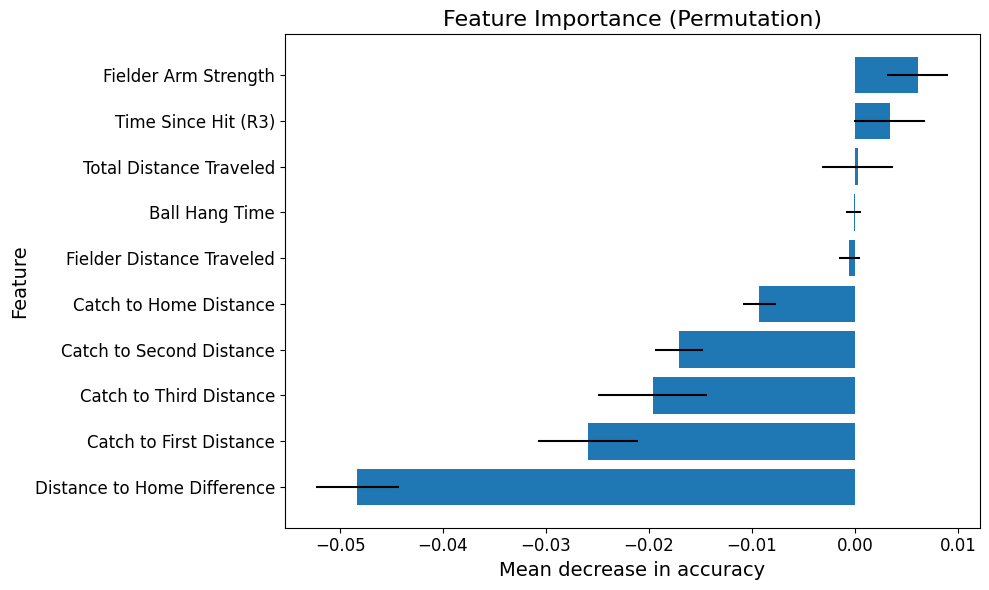

In [34]:
feature_aliases = {
    'arm_overall_fielder_mlb_person_id': 'Fielder Arm Strength',
    'seconds_since_hit_085_mlb_person_id_R3': 'Time Since Hit (R3)',
    'distance_traveled_all_fielders': 'Total Distance Traveled',
    'hang_time': 'Ball Hang Time',
    'distance_traveled_fielder': 'Fielder Distance Traveled',
    'distance_catch_to_home': 'Catch to Home Distance',
    'distance_catch_to_second': 'Catch to Second Distance',
    'distance_catch_to_third': 'Catch to Third Distance',
    'distance_catch_to_first': 'Catch to First Distance',
    'distance_to_home_diff': 'Distance to Home Difference'
}
# Permutation importance
result = permutation_importance(
    pipeline, X_test, y_test, n_repeats=20, random_state=123, n_jobs=-1
)
# Create a dataframe of feature importance
feature_names = list(feature_names)
perm_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': result.importances_mean,
    'Std': result.importances_std,
}).sort_values('Importance', ascending=True)
# Apply aliases to the dataframe
perm_importance['Feature_Display'] = perm_importance['Feature'].map(feature_aliases)
# Plot Permutation Importance
plt.figure(figsize=(10, 6))
plt.barh(perm_importance['Feature_Display'], perm_importance['Importance'], 
         xerr=perm_importance['Std'])
plt.title('Feature Importance (Permutation)', fontsize=16)
plt.xlabel('Mean decrease in accuracy', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()  # This helps prevent label cutoff
plt.show()

<Figure size 1000x800 with 0 Axes>

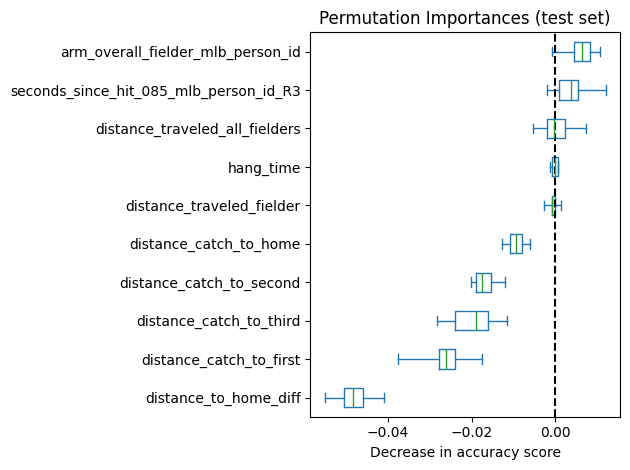

In [35]:
sorted_importances_idx = result.importances_mean.argsort()

importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X_test.columns[sorted_importances_idx], # X_test should have .columns
)

plt.figure(figsize=(10, 8)) # Adjust figure size as needed
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score") # Assumes default 'accuracy' scoring
ax.figure.tight_layout() # Use ax.figure to access the figure object
plt.show()

In [38]:
pipeline.named_steps['classifier']
importance = pipeline.named_steps['classifier'].coef_[0]  # For binary classification

                                  feature  importance  abs_importance
0                               hang_time   -0.055198        0.055198
2               distance_traveled_fielder   -0.092163        0.092163
1                  distance_catch_to_home   -0.236697        0.236697
6                distance_catch_to_second   -0.445402        0.445402
8  seconds_since_hit_085_mlb_person_id_R3    0.497722        0.497722
3          distance_traveled_all_fielders   -0.510367        0.510367
9       arm_overall_fielder_mlb_person_id    0.519700        0.519700
7                 distance_catch_to_third   -1.424150        1.424150
4                   distance_to_home_diff   -1.706475        1.706475
5                 distance_catch_to_first   -1.924856        1.924856


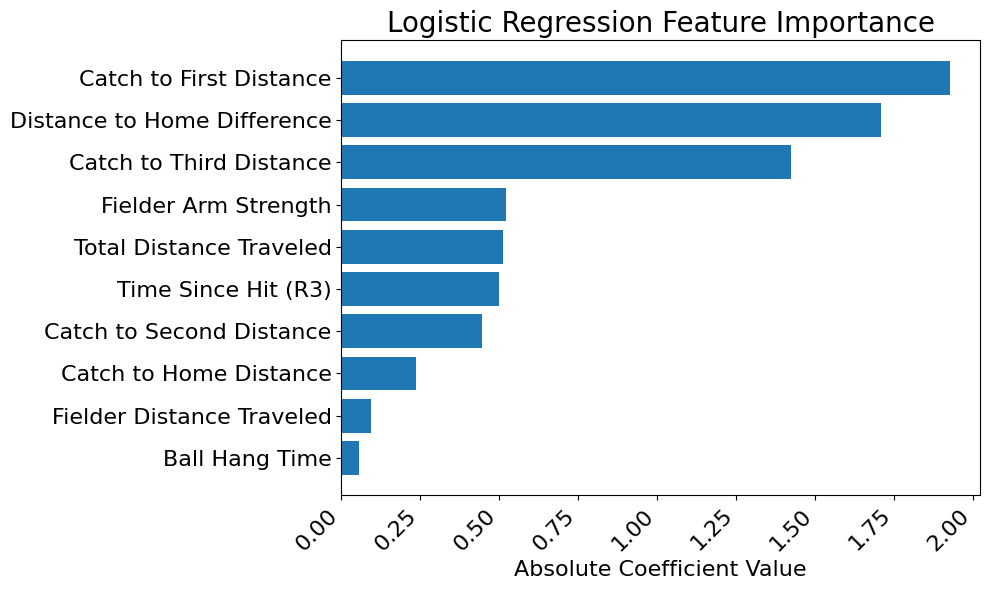

In [40]:
importance = pipeline.named_steps['classifier'].coef_[0]  # For binary classification

# Create a dictionary or DataFrame for easy viewing
import pandas as pd
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': importance,
    'abs_importance': np.abs(importance)  # Add absolute values
}).sort_values('abs_importance', ascending=True)  # Sort by absolute values
print(feature_importance)

feature_importance['feature_display'] = feature_importance['feature'].map(feature_aliases)

# Plot feature importance by magnitude
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature_display'], feature_importance['abs_importance'])  # Plot absolute values
plt.xlabel('Absolute Coefficient Value', fontsize=16)
plt.title('Logistic Regression Feature Importance', fontsize=20)
plt.xticks(rotation=45, ha='right', fontsize=16)
plt.yticks(rotation=0, fontsize=16)
plt.tight_layout()
plt.show()

## Censored Train and Censored Test, Limited Model (Distance to Home)

In [21]:
from models import model_prep_on_base, model_prep_on_base

# Load data
on_base_path = "../data/throw_home_runner_on_third_wide_sprint_arm.parquet"
on_base_lf = pl.scan_parquet(on_base_path)

# Feature column names
responses = ["is_out"]

num_predictors_drop = [
    "distance_catch_to_home"
]

num_predictors_median = [
]

# Parameter grid
param_grid = {
    'classifier__penalty': ['elasticnet'],
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
    'classifier__solver': ['saga'],
    'classifier__max_iter': [100, 250, 500, 1000]
}

# Scoring method
specificity_scorer = make_scorer(recall_score, pos_label=1)
precision_pos_scorer = make_scorer(precision_score, pos_label=1, zero_division=0)
f1_pos_scorer = make_scorer(f1_score, pos_label=1, zero_division=0)
scoring = {
    'log_loss': 'neg_log_loss',
    'brier_score': 'neg_brier_score'
}
refit = "brier_score"



# Train model
grid_search = create_model_pipeline(
    num_predictors_drop=num_predictors_drop,
    num_predictors_median=num_predictors_median,
    model_type="LogisticRegression",
    oversampling_method="SMOTE",
    param_grid=param_grid,
    scoring=scoring,
    refit=refit,
    cv=5,
)

# Censored Train and Censored Test
results = model_prep_on_base(
    on_base_lf = on_base_lf,
    grid_search = grid_search,
    responses = responses,
    num_predictors_drop = num_predictors_drop,
    num_predictors_median = num_predictors_median,
    test_size = 0.30,
    is_out_censored = True,
    test_stay_to_out = False,
    test_stay_to_out_threshold = True,
)

pipeline = results['pipeline']
X_train = results['X_train']
X_test = results['X_test']
y_train = results['y_train']
y_test = results['y_test']
y_pred = results['y_pred']
y_pred_proba = results['y_pred_proba']
brier_score = results['brier_score']
log_loss = results['log_loss']
feature_names = results['feature_names']
response_names = results['response_names']

pipeline

Total features: 2
Total Predictors: 1
Total Responses: 1
Fitting 5 folds for each of 120 candidates, totalling 600 fits

Best parameters: 
classifier__C = 10
classifier__l1_ratio = 0.5
classifier__max_iter = 100
classifier__penalty = elasticnet
classifier__solver = saga

Best cross-validation score: -0.0535

              precision    recall  f1-score   support

       False       0.99      0.92      0.95      1450
        True       0.72      0.95      0.82       323

    accuracy                           0.92      1773
   macro avg       0.85      0.93      0.88      1773
weighted avg       0.94      0.92      0.93      1773

Brier Score: 0.0568
log loss: 0.1986

Predictors:
distance_catch_to_home

Response:
is_out


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_drop',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['distance_catch_to_home'])])),
                ('oversampler', SMOTE(random_state=123)),
                ('classifier',
                 LogisticRegression(C=10, l1_ratio=0.5, penalty='elasticnet',
                                    random_state=123, solver='saga'))])

In [22]:
threshold = pd.concat([pd.DataFrame(X_test), pd.DataFrame(y_pred_proba)], axis=1)
threshold = threshold[(threshold[0] > 0.49) & (threshold[0] < 0.50)]
threshold

,distance_catch_to_home,0
228,265.516485,0.493254
1244,265.361112,0.497940


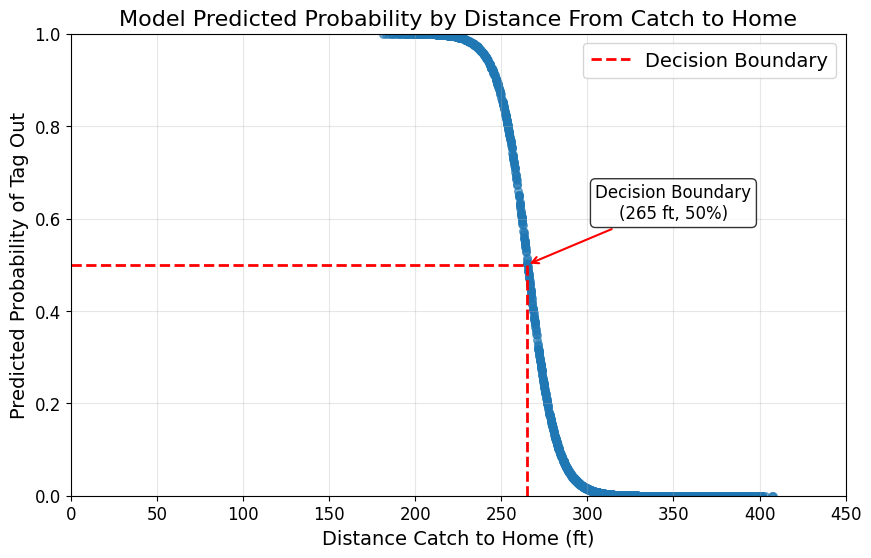

In [23]:
distance_catch_to_home_pd = X_test["distance_catch_to_home"]
plt.figure(figsize=(10, 6))
plt.scatter(distance_catch_to_home_pd, y_pred_proba, alpha=0.6, s=30)

# Create decision boundary lines that only extend to the intersection point
# Vertical line from bottom to y=0.5
plt.plot([265, 265], [0, 0.5], color='red', linestyle='--', linewidth=2, label='Decision Boundary')
# Horizontal line from left edge to x=265
plt.plot([0, 265], [0.5, 0.5], color='red', linestyle='--', linewidth=2)

# Add annotation with arrow pointing to the intersection
plt.annotate('Decision Boundary\n(265 ft, 50%)', 
             xy=(265, 0.5),  # Point to annotate (intersection)
             xytext=(350, 0.6),  # Text position (offset to the right and up)
             arrowprops=dict(arrowstyle='->', 
                           color='red', 
                           lw=1.5),
             fontsize=12,  # Consistent with labels
             ha='center',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

plt.xlabel('Distance Catch to Home (ft)', fontsize=14)
plt.ylabel('Predicted Probability of Tag Out', fontsize=14)
plt.title('Model Predicted Probability by Distance From Catch to Home', fontsize=16)
plt.xlim([0, 450])
plt.ylim([0, 1])
plt.legend(fontsize=14)
plt.grid(True, alpha=0.3)

# Make tick labels consistent too
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()